# USA Migration
### Data Engineering Capstone Project

#### Project Summary

TODO: We use X datasets to find Y relationships. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up


### Step 1: Scope the Project and Gather Data

#### Scope 

In the following project, we will show how to leverage the Cloud to create a Data Lake. We will use I94 Immigration data sponsored by Udacity, as well as other open data sources. The objective is to run analytics on the data and showcase the powers of a Serverless Infrastructure.

The Technologies we will be leveraging are:

  - **Storage**: AWS S3
  - **Infrastructure as Code**: Pulumi TypeScript SDK for AWS
  - **ETL Jobs**: AWS Glue and Spark
  - **Analytics:** AWS Athena

The end solution will appear at the end of the notebook in the form of Visualizations based on Analytics Queries on our Data Lake.

#### Describe and Gather Data 

We will be using a total of 4 Data Sources. All data used is provided by Udacity, but we will be talking more about each source's background.

  - **I94 Immigration Data**: Original comes from [US National Tourism and Trade Office](https://travel.trade.gov/research/reports/i94/historical/2016.html).
  - **World Temperature Data**: Original Source is [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
  - **U.S. City Demographic Data**: Original comes from [OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
  - **Airport Code Table**: Original comes from [Datahub](https://datahub.io/core/airport-codes#data).


In [59]:
# IMPORTS

import pandas as pd
from os import path 
from glob import glob
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

#### I94 Immigration Data

Immigration data from 2016 contains data related to an I94 Stamp, the Port of Entry and Flight Data (if Applicable), and some minimal information about the Person. Udacity provided data in SAS, Parquet, and CSV format, but all three are mostly the same, with CSV containing one extra unnamed column. When working with Big Data, the size format can make a massive difference in costs. The SAS and CSV file formats are considerably larger than parquet, so our initial stage will be to use a pipeline to transform SAS to Parquet and then use parquet on our Queries.

  - `I94YR`: 4 digit year.
  - `I94MON`: Numeric month.
  - `I94CIT & I94RES`: This format shows all the valid and invalid codes for processing.
  - `I94PORT`: This format shows all the valid and invalid codes for processing.
  - `ARRDATE`: the Arrival Date in the USA. It is a SAS date numeric field that a 
  - `I94MODE`: There are missing values as well as not reported (9).
    - 1 = Air
    - 2 = Sea
    - 3 = Land
    - 9 = Not Reported
  - `I94ADDR`: There is lots of invalid codes in this variable and the list below 
  - `DEPDATE`: the Departure Date from the USA. It is a SAS date numeric field that permament format has not been applied.
  - `I94BIR`: Age of Respondent in Years.
  - `I94VISA`: Visa codes collapsed into three categories:
    - 1 = Business
    - 2 = Pleasure
    - 3 = Student
  - `COUNT`: Used for summary statistics.
  - `DTADFILE`: Character Date Field - Date added to I-94 Files - CIC does not use.
  - `VISAPOST`: Department of State where where Visa was issued - CIC does not use.
  - `OCCUP`: Occupation that will be performed in U.S. - CIC does not use.
  - `ENTDEPA`: Arrival Flag - admitted or paroled into the U.S. - CIC does not use.
  - `ENTDEPD`: Departure Flag - Departed, lost I-94 or is deceased - CIC does not use.
  - `ENTDEPU`: Update Flag - Either apprehended, overstayed, adjusted to perm residence - CIC does not use.
  - `MATFLAG`: Match flag - Match of arrival and departure records.
  - `BIRYEAR`: 4 digit year of birth.
  - `DTADDTO`: Character Date Field - Date to which admitted to U.S. (allowed to stay until) - CIC does not use.
  - `GENDER`: Non-immigrant sex.
  - `INSNUM`: INS number.
  - `AIRLINE`: Airline used to arrive in U.S.
  - `ADMNUM`: Admission Number.
  - `FLTNO`: Flight number of Airline used to arrive in U.S.
  - `VISATYPE`: Class of admission legally admitting the non-immigrant to temporarily stay in U.S.
    - `B-1`: Visa Holders-Business
    - `B-2`: Visa Holders-Pleasure
    - `E-1`: Visa Holders-Treaty Trader
    - `E-2`: Visa Holders-Treaty Investor
    - `F-1`: Visa Holders-Students
    - `F-2`: Visa Holders-Family Members of Students
    - `I`: Visa Holders-Foreign Information Media
    - `M-1`: Visa Holders-Vocational Students
    - `M-2`: Visa Holders-Family Members of Vocational Students
    - `GMB`: Guam Visa Waiver-Business
    - `GMT`: Guam Visa Waiver-Tourist
    - `WB`: Visa Waiver-Business
    - `WT`: Visa Waiver-Pleasure

In [60]:
sas_data_parquet = glob('./sas-data/*.parquet')
immigration_data_full = glob('./immigration-data/18-83510-I94-Data-2016/*.sas7bdat')
immigration_data_sample = './immigration_data_sample.csv'

In [61]:
for chunk in pd.read_sas(immigration_data_full[0], format='sas7bdat', encoding="ISO-8859-1", chunksize=5):
    display(chunk.iloc[:2])
    print(chunk.columns.tolist())
    break

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,46.0,2016.0,12.0,129.0,129.0,HOU,20789.0,1.0,TX,20802.0,46.0,1.0,1.0,20161201,MDD,NaN,H,O,NaN,M,1970.0,05262018,M,NaN,RS,9.755414e+10,7715,E2
1,56.0,2016.0,12.0,245.0,245.0,NEW,20789.0,1.0,OH,20835.0,28.0,3.0,1.0,20161201,BEJ,NaN,U,O,NaN,M,1988.0,D/S,F,NaN,CA,9.062372e+10,819,F1


['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype']


In [62]:
immigration_data_df_from_parquet = pd.read_parquet(sas_data_parquet[0])
immigration_data_df_from_parquet.iloc[:2]

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,459651.0,2016.0,4.0,135.0,135.0,ATL,20547.0,1.0,FL,20559.0,54.0,2.0,1.0,20160403,None,None,O,R,None,M,1962.0,07012016,None,None,VS,5.555625e+10,00115,WT
1,459652.0,2016.0,4.0,135.0,135.0,ATL,20547.0,1.0,FL,20555.0,74.0,2.0,1.0,20160403,None,None,T,O,None,M,1942.0,07012016,F,None,VS,6.744065e+08,103,WT


In [63]:
immigration_data_df_from_sample = pd.read_csv(immigration_data_sample)
immigration_data_df_from_sample.iloc[:2]

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2


#### World Temperature Data

World temperature data comes from Kaggle by Berkeley Earth. It contains temperatures dating back to 1750. We will not be using the full dataset, as we're only interested in what relationships we can find to our Immigration data.

In [64]:
temperature_data = './temperature-data/GlobalLandTemperaturesByCity.csv'
display(temperature_data_df.iloc[:2])

,Date,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### US City Demographic Data

US Cities demographics data contains census information on places with a population equal to or more than 65,000, and it dates to 2015. The date is relevant because we can't infer causality of the Immigration data on this dataset. 

In [65]:
demographic_data = './us-cities-demographics.csv'
demographic_data_df = pd.read_csv(demographic_data, sep=';')
demographic_data_df.iloc[:2]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723


#### Airport Code Table

Airport Codes come from Datahub.io, and it dates to 2018. An airport code might refer to the IATA airport code, a three-letter airport code that could appear on the Immigration record, or the ICAO airport code, which is a four-letter code used by ATC systems. Immigration records do not specify a standard on their airport columns, and, likely, this data is not available. This statement does not mean one can't join the Immigration records with the Airport Codes, but it is not straightforward, and we will likely maintain all airport records because of that.

In [66]:
airport_codes = './airport-codes.csv'
airport_codes_df = pd.read_csv(airport_codes)
display(airport_codes_df.iloc[:2])
display(airport_codes_df[(airport_codes_df.ident.str.contains('CA')) & (airport_codes_df.iso_region.str.contains('OH'))])
print(airport_codes_df.shape)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
26334,KCAK,medium_airport,Akron Canton Regional Airport,1228.0,NaN,US,US-OH,Akron,KCAK,CAK,CAK,"-81.44219970703125, 40.916099548339844"


(55075, 12)


### Step 2: Explore and Assess the Data

#### Explore the Data 

Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps - Immigration Data

  - Transform all Integer Variables.
  - Transform dates in different formats to datetime.
  - Translate variables `i94cit`, `i94res`.

In [71]:
from datetime import datetime, timedelta
from numpy import nan
from pyspark.sql import SparkSession, SQLContext, GroupedData
from pyspark.sql.functions import *

def parser(days): 
    if pd.isnull(days):
        return nan
    return datetime(1960, 1, 1) + timedelta(int(float(days)))

def parser_dtadfile(date_string): 
    if pd.isnull(date_string):
        return nan
    if not isinstance(date_string, str):
        parts = str(date_string).split(".")[0]
        return datetime.strptime(parts, "%Y%m%d")
    return datetime.strptime(date_string, "%Y%m%d")

def parser_dtaddto(date_string): 
    if pd.isnull(date_string):
        return nan
    if date_string == "D/S": # duration of status
        return date_string
    if not isinstance(date_string, str):
        parts = str(date_string).split(".")[0]
        return datetime.strptime(parts, "%m%d%Y")
    return datetime.strptime(date_string, "%m%d%Y")

immigration_cols = [
    'cicid', 'i94yr', 'i94mon', 
    'i94cit', 'i94res', 'i94port',
    'arrdate', 'i94mode', 'i94addr',
    'depdate', 'i94bir', 'i94visa', 
    'count', 'dtadfile', 'visapost', 
    'occup', 'entdepa', 'entdepd', 
    'entdepu', 'matflag', 'biryear', 
    'dtaddto', 'gender', 'insnum', 
    'airline', 'admnum', 'fltno', 
    'visatype'
]

integer_columns = ['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94mode', 'i94bir', 'i94visa', 'count', 'biryear', 'gender', 'insnum', 'admnum']

# Parsing SAS Files
# The whole file is ~500mb and processing locally might take a long time
CHUNK_SIZE=5
for chunk in pd.read_sas(immigration_data_full[0], format='sas7bdat', encoding="ISO-8859-1", chunksize=CHUNK_SIZE):
    chunk[integer_columns] = chunk[integer_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')
    chunk['arrdate'] = chunk['arrdate'].apply(parser)
    chunk['depdate'] = chunk['depdate'].apply(parser)
    chunk['dtadfile'] = chunk['dtadfile'].apply(parser_dtadfile)
    chunk['dtaddto'] = chunk['dtaddto'].apply(parser_dtaddto)
    display(chunk.iloc[:2]) # chunk is size CHUNK_SIZE
    break
    

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,46,2016,12,129,129,HOU,2016-12-01,1,TX,2016-12-14,46,1,1,2016-12-01,MDD,NaN,H,O,NaN,M,1970,2018-05-26 00:00:00,NaN,NaN,RS,97554138030,7715,E2
1,56,2016,12,245,245,NEW,2016-12-01,1,OH,2017-01-16,28,3,1,2016-12-01,BEJ,NaN,U,O,NaN,M,1988,D/S,NaN,NaN,CA,90623718230,819,F1


In [75]:
# Cleaning Parquet File

immigration_data_df_from_parquet[integer_columns] = immigration_data_df_from_parquet[integer_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')
immigration_data_df_from_parquet['arrdate'] = immigration_data_df_from_parquet['arrdate'].apply(parser)
immigration_data_df_from_parquet['depdate'] = immigration_data_df_from_parquet['depdate'].apply(parser)
immigration_data_df_from_parquet['dtadfile'] = immigration_data_df_from_parquet['dtadfile'].apply(parser_dtadfile)
immigration_data_df_from_parquet['dtaddto'] = immigration_data_df_from_parquet['dtaddto'].apply(parser_dtaddto)

display(immigration_data_df_from_parquet.iloc[:1])

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,459651,2016,4,135,135,ATL,2016-04-03,1,FL,2016-04-15,54,2,1,2016-04-03,None,None,O,R,None,M,1962,2016-07-01 00:00:00,NaN,NaN,VS,55556253633,00115,WT


In [73]:
# Cleaning CSV
immigration_data_df_from_sample = pd.read_csv(immigration_data_sample,
                                              parse_dates=[7, 10],
                                              date_parser=parser,
                                              header=0)

immigration_data_df_from_sample[integer_columns] = immigration_data_df_from_sample[integer_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')

immigration_data_df_from_sample['dtadfile'] = immigration_data_df_from_sample['dtadfile'].apply(parser_dtadfile)
immigration_data_df_from_sample['dtaddto'] = immigration_data_df_from_sample['dtaddto'].apply(parser_dtaddto)
immigration_data_df_from_sample.iloc[:1]


,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316,2016,4,209,209,HHW,2016-04-22,1,HI,2016-04-29,61,2,1,2016-04-22,NaN,NaN,G,O,NaN,M,1955,2016-07-20 00:00:00,NaN,NaN,JL,56582674633,00782,WT


In [77]:
spark = SparkSession \
            .builder \
            .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11") \
            .enableHiveSupport() \
            .getOrCreate()

In [ ]:
immigration_data_full[0]

#### Cleaning Steps - World Temperature Data

  - Parse Dates
  - Only take US temperatures

In [48]:

temperature_data_df = pd.read_csv(temperature_data, parse_dates=['dt'])
temperature_data_df.rename(columns = {'dt':'Date'}, inplace = True)

display(temperature_data_df.head())


display(temperature_data_df[temperature_data_df.Country.str.contains("United States")].head())

,Date,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


,Date,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
47556,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W
47557,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W
47558,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W
47559,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W


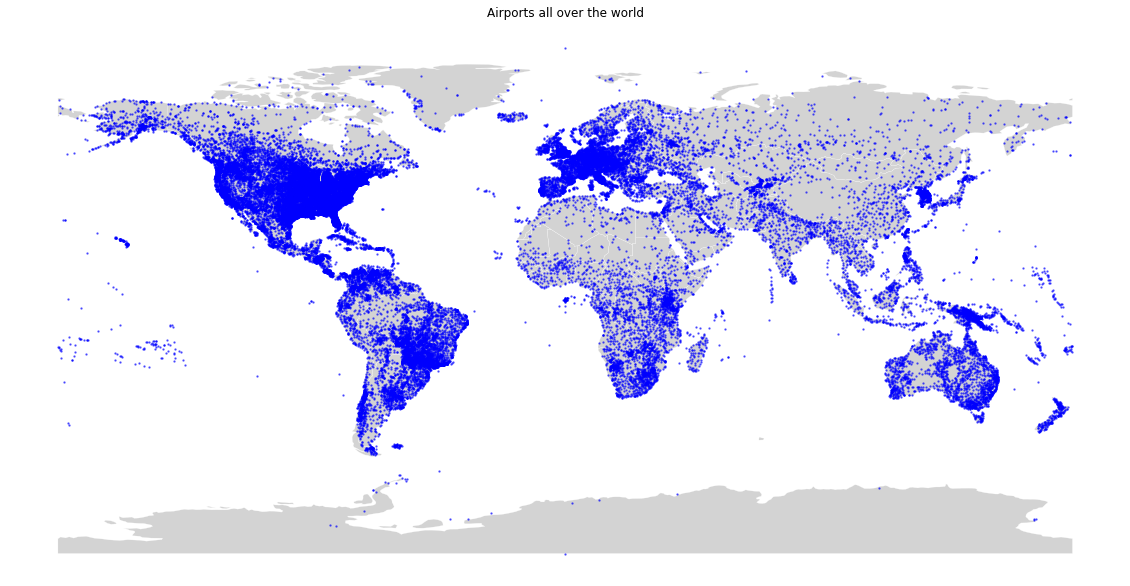

In [9]:
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

import warnings

warnings.filterwarnings('ignore')

def latlong_string_to_Point(lat_long):
    return Point(list(map(float, lat_long.split(','))))

crs = { 'init': 'epsg:4326' }
geometry = [latlong_string_to_Point(xy) for xy in airport_codes_df['coordinates']]

geo_df = gpd.GeoDataFrame(airport_codes_df, crs = crs, geometry = geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(20,12), linewidth=0.25, edgecolor='white', color='lightgrey')
geo_df.plot(markersize=2, color='blue', alpha=0.5, ax=ax)
ax.axis('off')
plt.title("Airports all over the world")
plt.show()

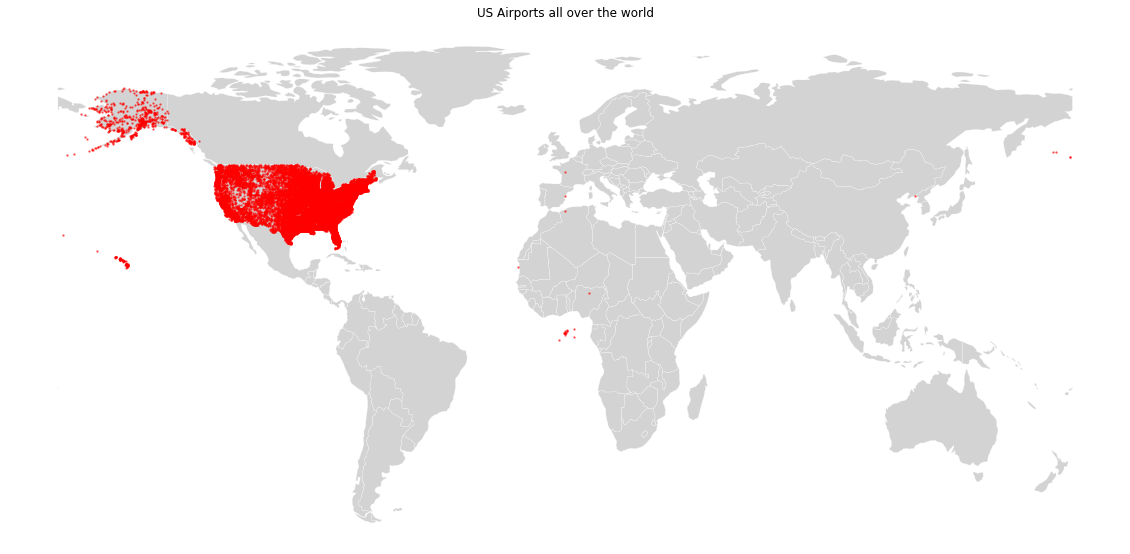

In [10]:
us_airport_codes_df = airport_codes_df[airport_codes_df['iso_country'] == "US"]
geometry = [latlong_string_to_Point(xy) for xy in us_airport_codes_df['coordinates']]

geo_df = gpd.GeoDataFrame(us_airport_codes_df, crs = crs, geometry = geometry)

world_no_antarctica = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

ax = world_no_antarctica.plot(figsize=(20,12), linewidth=0.25, edgecolor='white', color='lightgrey')
geo_df.plot(markersize=2, color='red', alpha=0.5, ax=ax)
ax.axis('off')
plt.title("US Airports all over the world")
plt.show()

#### Cleaning Steps - Demographics Data and Airport Codes

  - Only Select States that are part of Facts Table


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

For our business purpose, we will use the following questions:

  - What are the types of immigrants in the US? Relationship between profession and Visa Type.
  - What is the Country that migrates the most to/from the US? Provide a Visualization of which Country and encode amount as color density.
  - Statistics (`AVG`, `MEDIAN`, `STDDEV`) per Port, Airport, Visa Type, Gender, Birth Year, and MIN MAX of Counts per Day, Month, Year.
  - Which airline brings most visitors per month?

To answer these questions, we will create a Star Schema using a Fact Table named `facts_i94_records`, and multiple dimension tables: `dim_time`, `dim_visa`, `dim_airline`, `dim_person`, and `dim_port_of_entry`.  

Our Immigration data comes from ITA National Travel & Tourism Office, and it is published monthly, quarterly, and annually. For the project, we will create a "yearly" pipeline. Thus we will partition our Parquet files by year first. 

#### 3.2 Mapping Out Data Pipelines

We will use the SAS Files are the Start Trigger of the Pipeline. 
  1. Job to Ingest SAS and CSV files from S3 and create staging tables in parquet using Spark, then delete source files due to their size.
  2. Once job finishes, apply a second Job using Spark to read from Parquet sources and create the Star Schema.
  3. Perform data quality queries.
  4. Perform analytics.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.